In [8]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [9]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [209]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [439]:
from make_line import make_data, get_grid, get_code

In [403]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

szx,szy,szz=64,64,64
smx,smy=8,8
x_train, y_train0, y_train1 = make_data(N=10)
x_val, y_val0, y_val1 = make_data(N=10)
x_test, y_test0, y_test1 = make_data(N=5)
grid, grid_anchor = get_grid()

[[3 6]
 [5 4]]
30 3 8 6 0
44 5 8 4 0


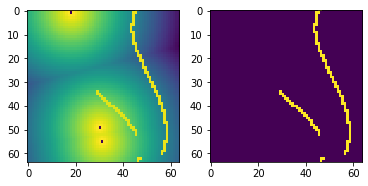

In [417]:
ind = -2
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,:,-1]==1)
print(region)
tmp = np.zeros((szx,szy))
if len(region.squeeze().shape) > 0:
    for x,y in region:
        code = smx*x+y
        print(code,x,smx,y,np.sum(y_train1[ind,x,y,code]))
        tmp[y_train1[ind,:,:,code].squeeze()==1]=r+1
plt.subplot(122)
plt.imshow(tmp)

In [379]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers


In [443]:
def viz_results(x_test,y_test0,ytest1,pred,szx,szy):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))
        #print(pred[0][ind,:,:,obj_ind])
        maxval = np.max(pred[0][ind,:,:,obj_ind])
        argmax = np.argwhere(pred[0][ind,:,:,obj_ind]==maxval)
        argmaxx,argmaxy=argmax[0]
        print(print(argmax.shape),argmax[0])
        
        print('pred',pred[0][ind,argmaxx,argmaxy,:])
        print('true',y_test0[ind,argmaxx,argmaxy,:])
        print('------')
        
        # GROUND TRUTH
        sa=plt.subplot(331)
        plt.title('sample index: {}, t:green, p:blue'.format(ind))
        sa.imshow(x_test[ind,:].squeeze())
        
        # overlay bounding box
        argmax = get_code(argmaxx,argmaxy,smx)
        ax,ay=grid_anchor[argmax]
        x,y,w,h,o = pred[0][ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='b',facecolor='none')
        sa.add_patch(rect)
        
        x,y,w,h,o = y_test0[ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='g',facecolor='none')
        sa.add_patch(rect)
        
        obj_real = y_test0[ind,:,:,obj_ind].squeeze()
        
        plt.subplot(332)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        
        ax = plt.subplot(333)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(obj_real.ravel())
        ax.set_ylim(0,1)
        
        # PREDICTED
        
        obj = pred[0][ind,:,:,obj_ind].squeeze()
        
        plt.subplot(334)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        plt.subplot(335)
        plt.title('obj or not - pred - actual val'.format())
        plt.imshow(obj,vmin=0,vmax=1,cmap='gray')
        
        ax = plt.subplot(336)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(obj.ravel())
        ax.set_ylim(0,1)

        if len(pred)>1:
            plt.subplot(337)
            plt.title('mask - pred'.format())
            
            plt.title('argmax {}'.format(argmax))
            plt.imshow(pred[1][ind,argmaxx,argmaxy,:,:].squeeze(),cmap='gray')
            

In [468]:

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO
# actual yolos
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2
#   https://hackernoon.com/understanding-yolo-f5a74bbc7967

epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1])

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0], tf.multiply(y_true[...,-1],y_pred[...,0]))
    loss_py = tf.squared_difference(y_true[...,1], tf.multiply(y_true[...,-1],y_pred[...,1]))
    loss_wx = tf.squared_difference(y_true[...,2], tf.multiply(y_true[...,-1],y_pred[...,2]))
    loss_wy = tf.squared_difference(y_true[...,3], tf.multiply(y_true[...,-1],y_pred[...,3]))
    
    loss_pos = tf.add(loss_px,loss_py)
    loss_width = tf.add(loss_wx,loss_wy)
    
    coord_loss = tf.add(loss_pos,loss_width)
    #coord_loss = tf.multiply(y_true[...,-1],coord_loss)
    return tf.reduce_mean(coord_loss)

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], tf.truediv(2*intersect_areas,(union_areas+epsilon)) )
    
    return tf.reduce_mean(iou_loss)

def vec_loss(y_true, y_pred):
    
    lambda_obj = 1.0
    lambda_coord = 1.0
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)


def conv_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

def convt_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    input_tensor = Conv2DTranspose(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

MASK = 'MASK'
VECTOR = 'VECTOR'

inputs = Input(shape=(szx,szy,1))

dropoutrate = 0.0
# down sample
xd = conv_batch_lrelu(inputs, 16, 3)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 32, 3)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 64, 3)
xd=Dropout(dropoutrate)(xd)

xd = conv_batch_lrelu(xd, 128, 3,strides=1)
xd = Conv2D(64, (1,1), strides=1, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False)(xd)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 128, 3,strides=1)
xd=Dropout(dropoutrate)(xd)
xd = Conv2D(64, (1, 1), strides=1, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False)(xd)
xd = conv_batch_lrelu(xd, 128, 3,strides=1)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 128, 3,strides=1)
xd=Dropout(dropoutrate)(xd)
xd = Conv2D(5, (3, 3), strides=1, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False)(xd)
vecs=Activation('sigmoid')(xd)
#vecs=Activation('linear')(xd)
#vecs=Lambda(lambda x: K.clip(x,0.,1.))(vecs)

'''
# bottle neck
x=Flatten()(xd)
x=Dense(128,
    kernel_regularizer=regularizers.l2(0.0005),
    kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
    use_bias=False,
    )(x) # # filter size ratio between conv and dense needs to be tuned!
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(dropoutrate)(x)
x=Dense(128,
    kernel_regularizer=regularizers.l2(0.0005),
    kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
    use_bias=False,
    )(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(dropoutrate)(x) # attempt to prevent overfit...
x=Dense(smx*smy*5,
    kernel_regularizer=regularizers.l2(0.0005),
    kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
    use_bias=True,
    )(x)
x=Reshape((smx*smy,5))(x)

# output split - split output to have varying activations for pos,width, and obj
# output: pos and width
x_pos_width = Lambda(lambda x: x[..., 0:4])(x)
#x_pos_width=Activation('sigmoid')(x_pos_width)
x_pos_width=Activation('linear')(x_pos_width)
#x_pos_width=Lambda(lambda x: K.clip(x,0.,1.))(x_pos_width)

# output: sigmoid
x_obj = Lambda(lambda x: K.expand_dims(x[..., -1],axis=-1))(x)
x_obj=Activation('sigmoid')(x_obj)

# merge outputs
vecs = Concatenate(axis=-1,name=VECTOR)([x_pos_width,x_obj])
model = Model(inputs=inputs, outputs=vecs)

'''

model = Model(inputs=inputs, outputs=vecs)
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)


# very nice ref. https://github.com/ksanjeevan/dourflow/blob/master/yolov2.py
# opt.Adam, opt.RMSprop
verbose=1
batch_size=32
epochs=1000
lr=1E-4
decay=1E-3
patience=10
beta_1=0.9
beta_2=0.999

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience,
                              verbose=0,
                              mode='min')
callbacks = [early_stopping]

optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=vec_loss, optimizer=optimizer)
history = model.fit(x_train, y_train0,
                    batch_size=batch_size, epochs=epochs,
                    verbose=verbose, 
                    validation_data=(x_val, y_val0),
                    callbacks=callbacks)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 32, 32, 16)        144       
_________________________________________________________________
batch_normalization_403 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu_403 (LeakyReLU)  (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_386 (Dropout)        (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_331 (Conv2D)          (None, 16, 16, 32)        4608      
_________________________________________________________________
batch_normalization_404 (Bat (None, 16, 16, 32)        128       
__________

Epoch 35/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6469 - val_loss: 1.9617
Epoch 36/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6441 - val_loss: 1.9571
Epoch 37/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6422 - val_loss: 1.9527
Epoch 38/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6398 - val_loss: 1.9484
Epoch 39/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6373 - val_loss: 1.9442
Epoch 40/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6351 - val_loss: 1.9402
Epoch 41/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6330 - val_loss: 1.9364
Epoch 42/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6310 - val_loss: 1.9329
Epoch 43/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6294 - val_loss: 1.9295
Epoch 44/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.6273 - val_los

Epoch 116/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5468 - val_loss: 1.8128
Epoch 117/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5459 - val_loss: 1.8118
Epoch 118/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5451 - val_loss: 1.8108
Epoch 119/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5442 - val_loss: 1.8097
Epoch 120/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5433 - val_loss: 1.8087
Epoch 121/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5424 - val_loss: 1.8077
Epoch 122/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5414 - val_loss: 1.8066
Epoch 123/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5407 - val_loss: 1.8056
Epoch 124/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5398 - val_loss: 1.8046
Epoch 125/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5388

Epoch 197/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4780 - val_loss: 1.7406
Epoch 198/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4773 - val_loss: 1.7399
Epoch 199/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4764 - val_loss: 1.7391
Epoch 200/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4755 - val_loss: 1.7382
Epoch 201/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4747 - val_loss: 1.7375
Epoch 202/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4737 - val_loss: 1.7367
Epoch 203/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4730 - val_loss: 1.7359
Epoch 204/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4724 - val_loss: 1.7351
Epoch 205/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4714 - val_loss: 1.7342
Epoch 206/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4704

Epoch 278/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4131 - val_loss: 1.6780
Epoch 279/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4123 - val_loss: 1.6773
Epoch 280/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4116 - val_loss: 1.6767
Epoch 281/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4107 - val_loss: 1.6760
Epoch 282/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4100 - val_loss: 1.6752
Epoch 283/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4094 - val_loss: 1.6745
Epoch 284/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4087 - val_loss: 1.6738
Epoch 285/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4078 - val_loss: 1.6731
Epoch 286/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4071 - val_loss: 1.6724
Epoch 287/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4062

Epoch 359/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3533 - val_loss: 1.6219
Epoch 360/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3527 - val_loss: 1.6211
Epoch 361/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3520 - val_loss: 1.6206
Epoch 362/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3513 - val_loss: 1.6199
Epoch 363/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3506 - val_loss: 1.6192
Epoch 364/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3499 - val_loss: 1.6185
Epoch 365/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3492 - val_loss: 1.6178
Epoch 366/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3485 - val_loss: 1.6171
Epoch 367/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3478 - val_loss: 1.6165
Epoch 368/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3471

Epoch 440/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2980 - val_loss: 1.5702
Epoch 441/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2973 - val_loss: 1.5695
Epoch 442/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2968 - val_loss: 1.5689
Epoch 443/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2960 - val_loss: 1.5684
Epoch 444/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2954 - val_loss: 1.5678
Epoch 445/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2949 - val_loss: 1.5672
Epoch 446/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2941 - val_loss: 1.5666
Epoch 447/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2934 - val_loss: 1.5660
Epoch 448/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2930 - val_loss: 1.5653
Epoch 449/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2921

Epoch 521/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2467 - val_loss: 1.5226
Epoch 522/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2462 - val_loss: 1.5221
Epoch 523/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2457 - val_loss: 1.5216
Epoch 524/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2452 - val_loss: 1.5211
Epoch 525/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2446 - val_loss: 1.5205
Epoch 526/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2439 - val_loss: 1.5200
Epoch 527/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2432 - val_loss: 1.5195
Epoch 528/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2425 - val_loss: 1.5190
Epoch 529/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2421 - val_loss: 1.5184
Epoch 530/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2412

Epoch 602/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1992 - val_loss: 1.4788
Epoch 603/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1985 - val_loss: 1.4784
Epoch 604/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1980 - val_loss: 1.4779
Epoch 605/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1977 - val_loss: 1.4774
Epoch 606/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1970 - val_loss: 1.4768
Epoch 607/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1964 - val_loss: 1.4763
Epoch 608/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1958 - val_loss: 1.4758
Epoch 609/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1952 - val_loss: 1.4753
Epoch 610/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1948 - val_loss: 1.4748
Epoch 611/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1942

Epoch 683/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1553 - val_loss: 1.4385
Epoch 684/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1547 - val_loss: 1.4380
Epoch 685/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1542 - val_loss: 1.4375
Epoch 686/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1539 - val_loss: 1.4369
Epoch 687/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1532 - val_loss: 1.4364
Epoch 688/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1526 - val_loss: 1.4359
Epoch 689/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1524 - val_loss: 1.4356
Epoch 690/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1516 - val_loss: 1.4353
Epoch 691/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1512 - val_loss: 1.4349
Epoch 692/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1505

Epoch 764/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1146 - val_loss: 1.4018
Epoch 765/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1141 - val_loss: 1.4014
Epoch 766/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1135 - val_loss: 1.4009
Epoch 767/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1131 - val_loss: 1.4005
Epoch 768/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1126 - val_loss: 1.4001
Epoch 769/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1121 - val_loss: 1.3997
Epoch 770/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1117 - val_loss: 1.3992
Epoch 771/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1111 - val_loss: 1.3987
Epoch 772/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.1108 - val_loss: 1.3982
Epoch 773/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.1102

Epoch 845/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0770 - val_loss: 1.3677
Epoch 846/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0763 - val_loss: 1.3673
Epoch 847/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0759 - val_loss: 1.3669
Epoch 848/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0755 - val_loss: 1.3665
Epoch 849/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0751 - val_loss: 1.3660
Epoch 850/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0746 - val_loss: 1.3656
Epoch 851/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0741 - val_loss: 1.3652
Epoch 852/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0736 - val_loss: 1.3649
Epoch 853/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0733 - val_loss: 1.3645
Epoch 854/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0729

Epoch 926/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0418 - val_loss: 1.3360
Epoch 927/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0412 - val_loss: 1.3356
Epoch 928/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0407 - val_loss: 1.3351
Epoch 929/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0404 - val_loss: 1.3347
Epoch 930/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0400 - val_loss: 1.3344
Epoch 931/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0397 - val_loss: 1.3341
Epoch 932/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0391 - val_loss: 1.3338
Epoch 933/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0387 - val_loss: 1.3334
Epoch 934/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0384 - val_loss: 1.3330
Epoch 935/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.0380

dict_keys(['val_loss', 'loss'])

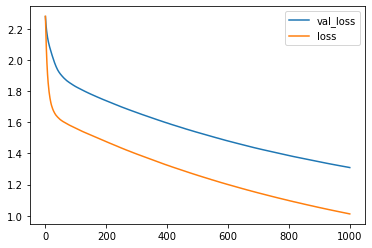

In [472]:
df = pd.DataFrame(history.history)
df.plot()
history.history.keys()

In [473]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = model.evaluate(x_0,y_0)
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = model.evaluate(x_0,y_0)
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = model.evaluate(x_0,y_0)
print('test',out)

10/10 [==============================] - 0s 1ms/step
train 1.0128350257873535
10/10 [==============================] - 0s 1ms/step
val 1.3091251850128174
5/5 [==============================] - 0s 2ms/step
test 1.269662857055664


(1, 2)
None [3 2]
pred [0.15438342 0.02124807 0.4343467  0.0565941  0.2943706 ]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [3 2]
pred [0.57982063 0.16368535 0.58984685 0.76754    0.4336574 ]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [5 2]
pred [0.05494186 0.44016656 0.04899022 0.03325954 0.16009569]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [1 1]
pred [0.3765999  0.16654736 0.25625002 0.09497279 0.17769414]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [5 3]
pred [0.35228813 0.3186057  0.8137416  0.03102788 0.52977633]
true [0.046875 0.109375 0.25     0.5      1.      ]
------


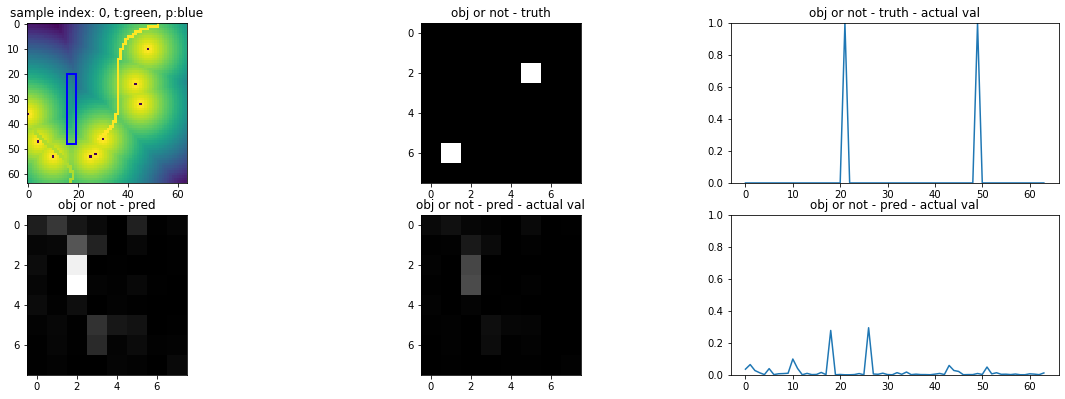

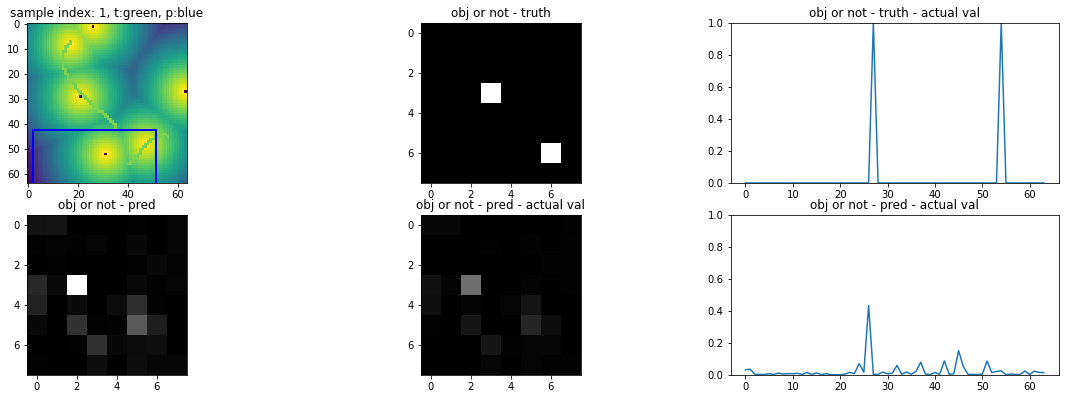

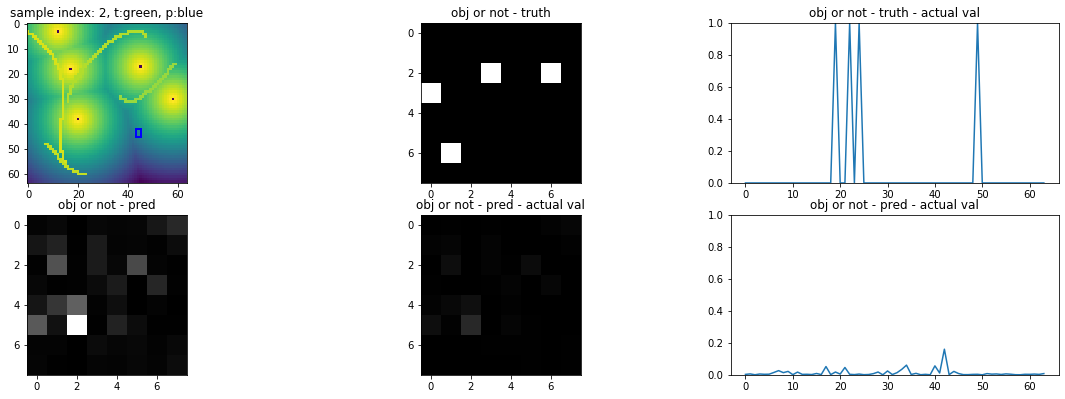

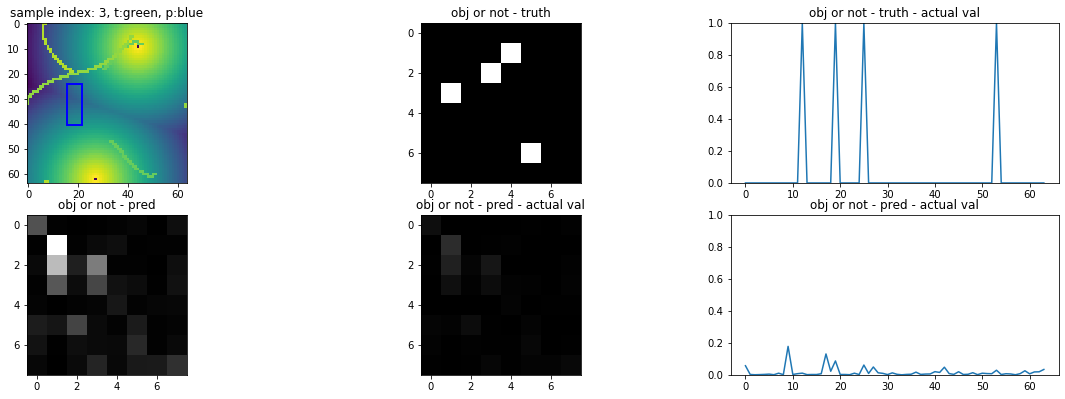

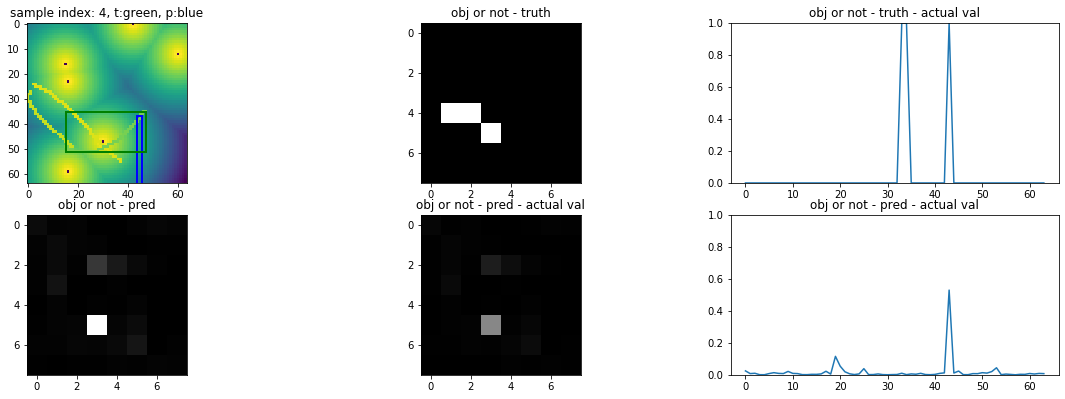

In [475]:
x_0, y_0, y_1 = x_test, y_test0, y_test1
#x_0, y_0, y_1 = x_train, y_train0, y_train1
#x_0, y_0, y_1 = x_val, y_val0, y_val1
pred = model.predict(x_0)
pred = [pred]
viz_results(x_0,y_0,y_1,pred,szx,szy)

In [ ]:
# !CUDA_VISIBLE_DEVICES=0 python line-yolo-hyper-param-search.py

In [290]:
from keras.models import load_model

best_model = load_model(
    'line-yolo-model.h5',
   custom_objects={
       'vec_loss':vec_loss,
       'compute_iou_loss':compute_iou_loss,
       'compute_coord_loss':compute_coord_loss,
       'compute_obj_loss':compute_obj_loss,
   },
)

1024/1024 [==============================] - 4s 4ms/step
train 0.17334033735096455
100/100 [==============================] - 0s 314us/step
val 0.1858407199382782
5/5 [==============================] - 0s 2ms/step
test 0.21340402960777283
27 pred [0.3052251  0.38328862 0.5931607  0.4868589  0.19350818]
27 true [0. 0. 0. 0. 0.]
------
27 pred [0.2885558  0.4056687  0.56175613 0.46107912 0.22946641]
27 true [0. 0. 0. 0. 0.]
------
35 pred [0.31092203 0.2733705  0.46066138 0.45245996 0.22113156]
35 true [0.0078125 0.09375   0.578125  0.3125    1.       ]
------
28 pred [0.27947277 0.41768065 0.6019406  0.56836164 0.1237134 ]
28 true [0. 0. 0. 0. 0.]
------
27 pred [0.31628782 0.36476067 0.5422807  0.5640247  0.21382532]
27 true [0. 0. 0. 0. 0.]
------


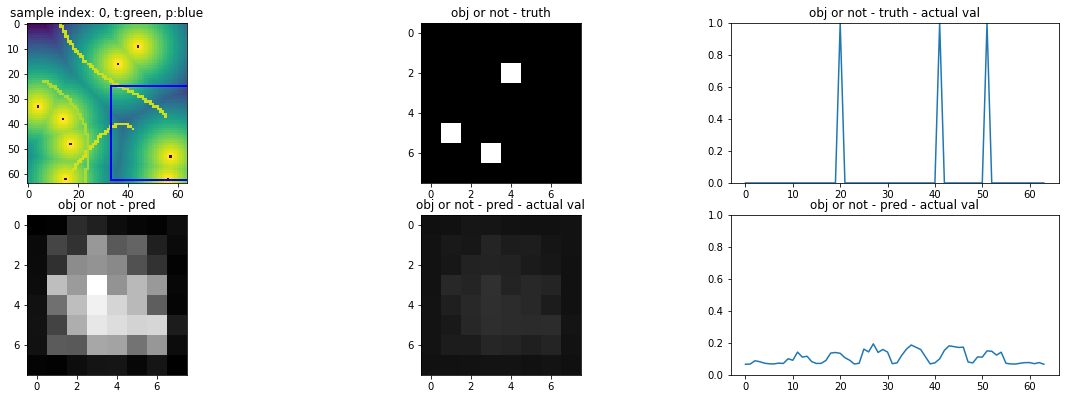

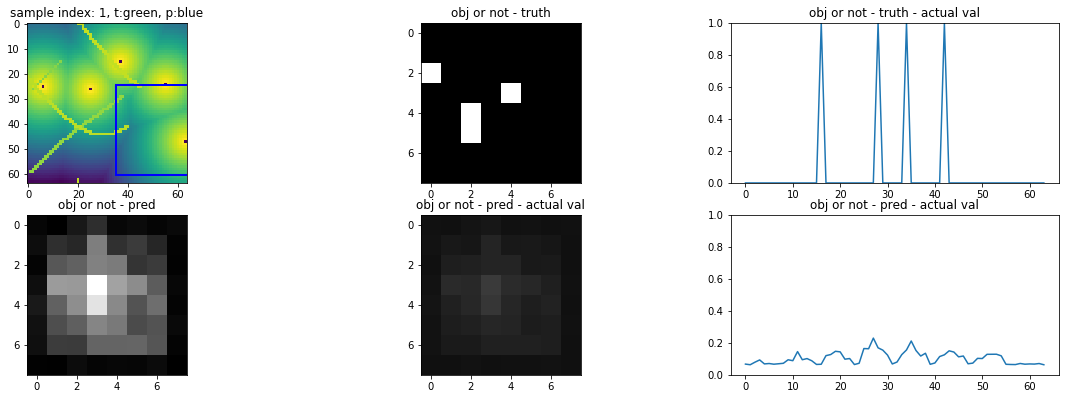

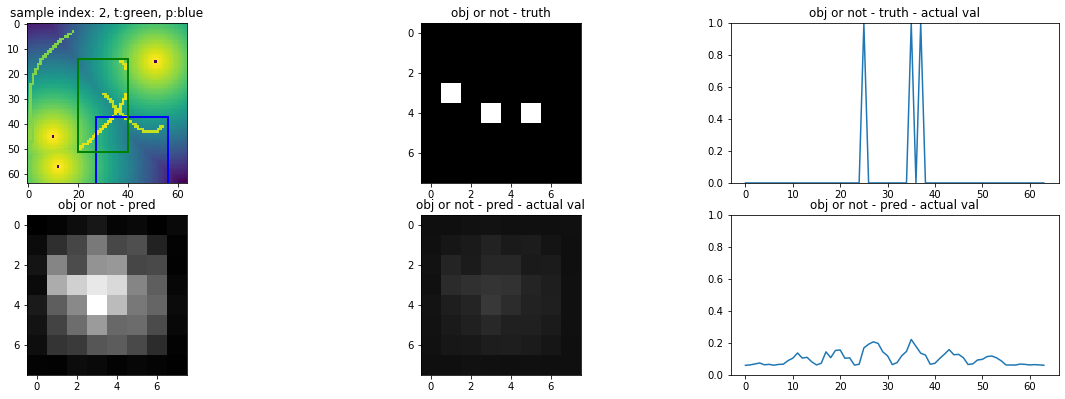

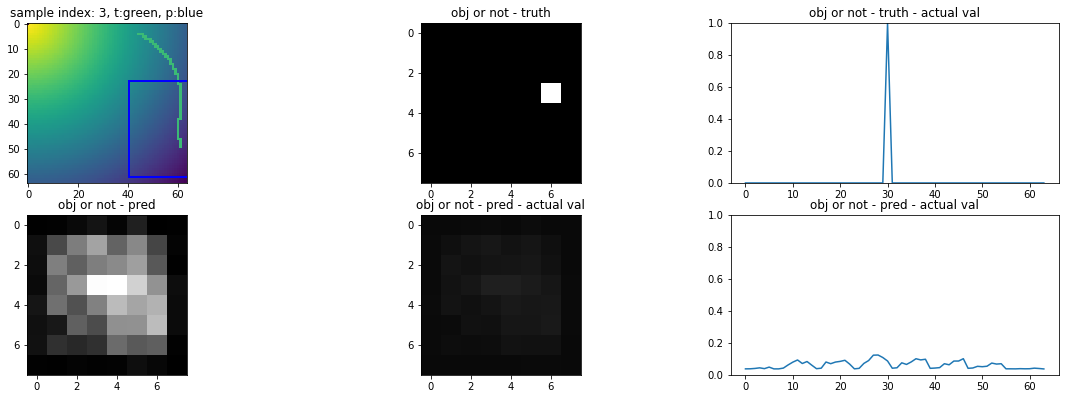

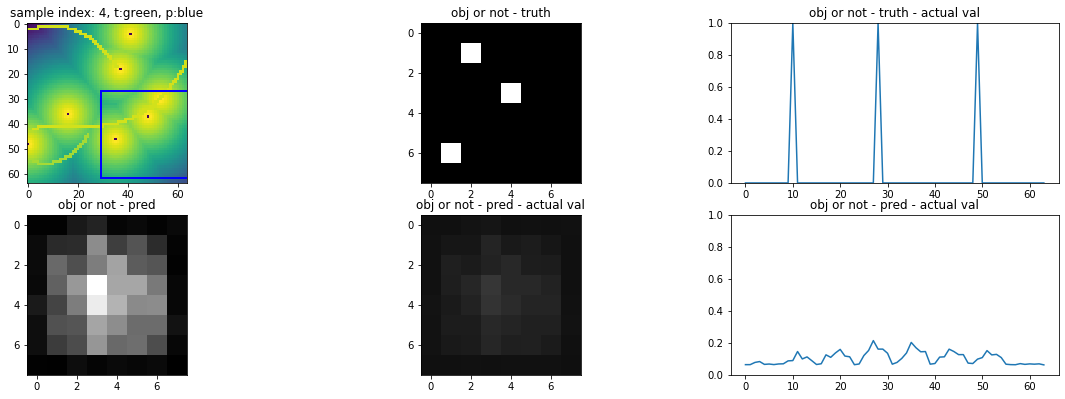

In [291]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = best_model.evaluate(x_0,y_0)
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = best_model.evaluate(x_0,y_0)
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = best_model.evaluate(x_0,y_0)
print('test',out)

x_0, y_0, y_1 = x_train, y_train0, y_train1
pred = best_model.predict(x_0)
viz_results(x_0,y_0,y_1,[pred],szx,szy)